[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/andreofner/pyGPC/blob/master/demo.ipynb)


In [4]:
!git clone https://github.com/andreofner/pyGPC

fatal: destination path 'pyGPC' already exists and is not an empty directory.
python3: can't open file 'GPC.py': [Errno 2] No such file or directory


In [14]:
cd pyGPC

/content/pyGPC


In [16]:
!python GPC.py

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3325952/45929032 bytes (7.2%)7184384/45929032 bytes (15.6%)10780672/45929032 bytes (23.5%)14663680/45929032 bytes (31.9%)18505728/45929032 bytes (40.3%)22200320/45929032 bytes (48.3%)26206208/45929032 bytes (57.1%)30007296/45929032 bytes (65.3%)33718272/45929032 bytes (73.4%)37576704/45929032 bytes (81.8%)41451520/45929032 bytes (90.3%)45268992/45929032 bytes (98.6%)

In [17]:
# Moving MNIST train and test predictions
# Run this cell twice if videos don't show 

from IPython.display import Image, display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Train set
print("TRAIN DATA")
Image(open('./figures/insMnist-Train-v0.gif','rb').read())
print("Inputs\n")
Image(open('./figures/p_hMnist-Train-v0.gif','rb').read())
print("Prediction from lowest hierarchical layer\n")
Image(open('./figures/p_gMnist-Train-v0.gif','rb').read())
print("Prediction from deepest hierarchical layer\n")

# Test set
print("\n\nTEST DATA")
Image(open('./figures/insMnist-Test-v0.gif','rb').read())
print("Inputs\n")
Image(open('./figures/p_hMnist-Test-v0.gif','rb').read())
print("Prediction from lowest hierarchical layer\n")
Image(open('./figures/p_gMnist-Test-v0.gif','rb').read())
print("Prediction from deepest hierarchical layer\n")

TRAIN DATA


Inputs



Prediction from lowest hierarchical layer



Prediction from deepest hierarchical layer



TEST DATA


Inputs



Prediction from lowest hierarchical layer



Prediction from deepest hierarchical layer



TRAIN DATA


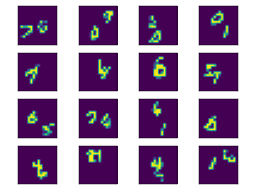

Inputs 



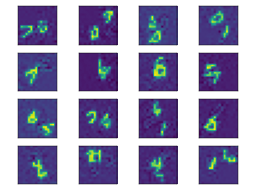

Predictions 



TEST DATA


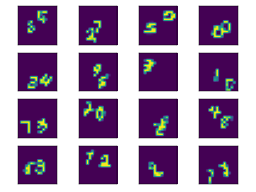

Inputs 



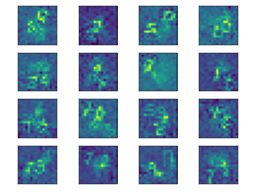

Predictions 



In [18]:
# Visualize batch of inputs and predictions

print("TRAIN DATA")
Image(open('./figures/Mnist-Train-v0input.png','rb').read())
print("Inputs \n")
Image(open('./figures/Mnist-Train-v0pred_g.png','rb').read())
print("Predictions \n")

print("\n\nTEST DATA")
Image(open('./figures/Mnist-Test-v0input.png','rb').read())
print("Inputs \n")
Image(open('./figures/Mnist-Test-v0pred_g.png','rb').read())
print("Predictions \n")

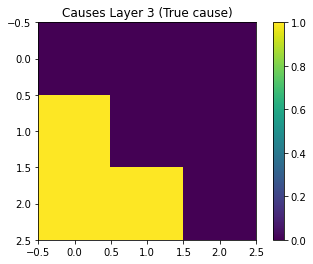

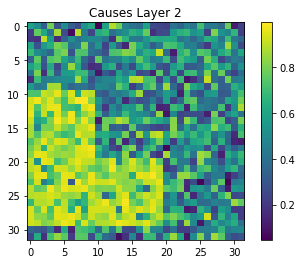

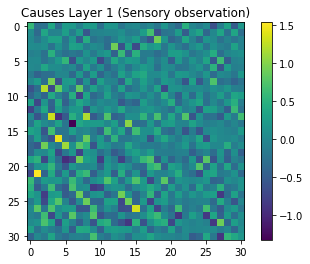

In [19]:
"""
Second order perception in the visual domain

Here, visual content is defined via second order statistics, i.e. without first-order perceptual content.
Recognizing second-order objects requires top-down prediction of precision.
This renders second order perception a suitable task to contrast GPC with other architectures.

This script generates data comparable to pubmed.ncbi.nlm.nih.gov/25823866 with
convolutional neural networks as the generative model.
Gaussian noise enters the data generating process via parameter initialization.

Second order perception requires the estimated precision to be dependent on hidden states
in higher layers, so that objects and their precision are predicted jointly.

André Ofner 2021
"""

import torch
import matplotlib.pyplot as plt
from torch import nn

# Layer 3 causes: Position of object
input = torch.zeros([1,1,3,3])
input[:,:,2,1] = 1
input[:,:,2,0] = 1
input[:,:,1,0] = 1

# Layer 2 causes: Position of object in sensory space
m = nn.ConvTranspose2d(1, 10, (10, 10), stride=10, padding=(0, 0), output_padding=(2, 2), bias=None)
torch.nn.init.ones_(m.weight);
output = m(input).mean(dim=1).unsqueeze(1)
output = torch.sigmoid(output*2+(torch.randn_like(output))) # add innovation

# Layer 1 causes (observable): Object in sensory space
m = nn.Conv2d(1, 10, (2, 2), stride=1, bias=False, padding_mode="reflect")
torch.nn.init.normal_(m.weight, 0, 1);
output2 = m((output*torch.randn_like(output))).mean(dim=1).unsqueeze(1);
output2 = output2;

plt.imshow(input.detach().numpy().reshape(input.shape[-1],input.shape[-1]));
plt.colorbar();
plt.title("Causes Layer 3 (True cause)");
plt.show();

plt.imshow(output.detach().numpy().reshape(output.shape[-1],output.shape[-1]));
plt.colorbar();
plt.title("Causes Layer 2");
plt.show();

plt.imshow(output2.detach().numpy().reshape(output2.shape[-1],output2.shape[-1]));
plt.colorbar();
plt.title("Causes Layer 1 (Sensory observation)");
plt.show();


In [25]:
# A bias for inference?

# Comparing gradient based predictive coding with and without activity gain optimization:
# 1) with activity gain : output =  weights(activity * activity_gain) + weights_bias
# 2) without activity gain : output = weights(activity) + weights_bias
# Activity gain = Modulatory (multiplicative) bias on activity

# Experiment:
#     - Pure inference (no weights optimization)
#     - randomly initialised ( N(0,1) ) activity
#     - optimize activity such that projection through weights fits another randomly initialised ( N(0,1) ) tensor

# Evaluation:
#     - updates up to convergence (loss <= 0.01)


import torch, numpy as np

UPDATES = 1000 # maximum allowed updates
length = np.array([0,0]) # store final results

for optimize_gain in [0,1]:
    for i in range(10):
        d = torch.randn(64).requires_grad_()  # activity
        b = torch.randn(64).requires_grad_()  # activity gain (multiplicative bias)
        w = torch.nn.Linear(64, 16, False)  # weights (optionally with additive bias)
        t = torch.randn(16)  # target
        opt_d = torch.optim.SGD([d], 0.1)  # activity optimizer
        opt_b = torch.optim.SGD([b], 0.1)  # activity gain optimizer

        for i in range(UPDATES):
            opt_d.zero_grad()

            if optimize_gain == 0:
                loss = torch.mean(((w(d)) - t) ** 2) # no multiplicative bias on activity
            else:
                loss = torch.mean(((w(d*b)) - t) ** 2)

            loss.backward()

            opt_d.step() # step activity
            if optimize_gain == 1: opt_b.step()  # step activity gain

            if loss <= 0.01 or i == (UPDATES-1):
                length[optimize_gain] += i
                break

length = length/10
print("Average updates to convergence without activity gain: ", length[0])
print("Average updates to convergence with activity gain: ", length[1])

Average updates to convergence without activity gain:  918.2
Average updates to convergence with activity gain:  318.7
